In [1]:
import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt
import time
import os

import numpy as np
import pandas as pd
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal

from fgan import fgan

# Assume that we are on a CUDA machine, then this should print a CUDA device:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%load_ext autoreload
%autoreload 2

cuda


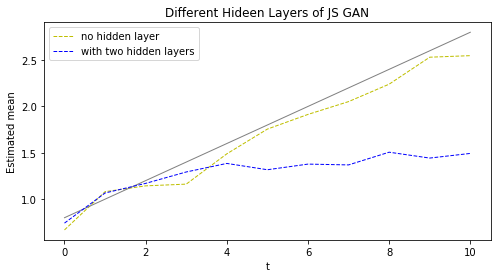

In [11]:
mean0=[]
mean1=[]
for t in range(11):
    XReal = np.random.normal(loc=1., scale=1., size=(4000, 2))
    XCont = np.random.normal(loc=t, scale=1., size=(1000, 2))
    XData = np.concatenate( (XReal, XCont), axis=0 )
    
    f4 = fgan(2, 0.0, device, epsilon=1e-5)
    f4.dist_init(true_type='Gaussian', cont_type='Gaussian',
                 c_cov=1.0, c_loc=1.0)
    f4.data_init(batch_size = 100, 
                 data = torch.from_numpy( XData[np.random.shuffle(np.arange(5000))].squeeze() ).float() )
    f4.net_init(hidden_units=[1], elliptical=False, use_bias=True,
               init_D='xavier', init_D1=0.025, init_G='kendall',
               activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

    f4.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
    f4.fit(floss='js', epochs=10, avg_epochs=20,
           verbose=25, show=False, logd_trick=False)
    
    f5 = fgan(2, 0.0, device, epsilon=1e-5)
    f5.dist_init(true_type='Gaussian', cont_type='Gaussian',
                 c_cov=1.0, c_loc=1.0)
    f5.data_init(batch_size = 100, 
                 data = torch.from_numpy( XData[np.random.shuffle(np.arange(5000))].squeeze() ).float() )
    f5.net_init(hidden_units=[100,25], elliptical=False, use_bias=True,
               init_D='xavier', init_D1=0.025, init_G='kendall',
               activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

    f5.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
    f5.fit(floss='js', epochs=10, avg_epochs=20,
           verbose=25, show=False, logd_trick=False)
    
    mean_0=f4.mean_avg[0]
    mean_1=f5.mean_avg[0]
    
    mean0.append(mean_0)
    mean1.append(mean_1)
import numpy as np
import matplotlib.pyplot as plt
import random 

x = [i for i in range(11)]
z=[0.8+0.2*i for i in x]
plt.figure(figsize=(8,4))

plt.plot(x,mean0,"y--",linewidth=1,label="no hidden layer")
plt.plot(x,z,"grey",linewidth=1) 
plt.plot(x,mean1,"b--",linewidth=1,label="with two hidden layers")
plt.xlabel("t")
 

plt.ylabel("Estimated mean")
 
plt.title("Different Hideen Layers of JS GAN")
 
plt.legend()
 

plt.show()

We select 50 stocks during the period between 2015-01-01 and 2020-04-01 from Yahoo! Finance. 

In [4]:
corps_dict = {
         "Industrial":["LMT", "HON", "UNP", "BA", "MMM", "UPS"],
         "ConsDiscr":["AMZN", "HD", "MCD", "NKE", "SBUX", "LOW"],
         "ConsStaples":["WMT", "PG", "KO", "PEP", "COST", "PM"],
         "Energy":["XOM", "CVX", "COP", "KMI", "PSX", "EOG"],
         "HealthCare":["JNJ", "UNH", "MRK", "PFE", "ABT", "LLY"],
         "Financial":["JPM", "BAC", "WFC", "C", "AXP", "BLK"],
         "InfoTech":["MSFT", "AAPL", "V", "MA", "INTC", "CSCO"],
         "Material":["LIN", "ECL", "APD", "NEM", "SHW", "DD"],
         "Utility":["NEE", "D", "DUK", "SO", "AEP", "SRE"],
         "CommSevs": ["GOOG", "FB", "VZ", "T", "DIS", "NFLX"]
            }

corps = []; sects = [] ## list of corporations and their corresponding sectors
for k, v in corps_dict.items():
    corps += v[:5]
    sects += [k] * 5

tks = yf.Tickers( " ".join(corps) )

START = "2015-01-01"; END = "2020-04-01"
df_price = tks.history(start=START, end=END)["Close"]
df_price = df_price[corps]

[*********************100%***********************]  50 of 50 completed


### Visualizing the return of stocks selected from different sectors

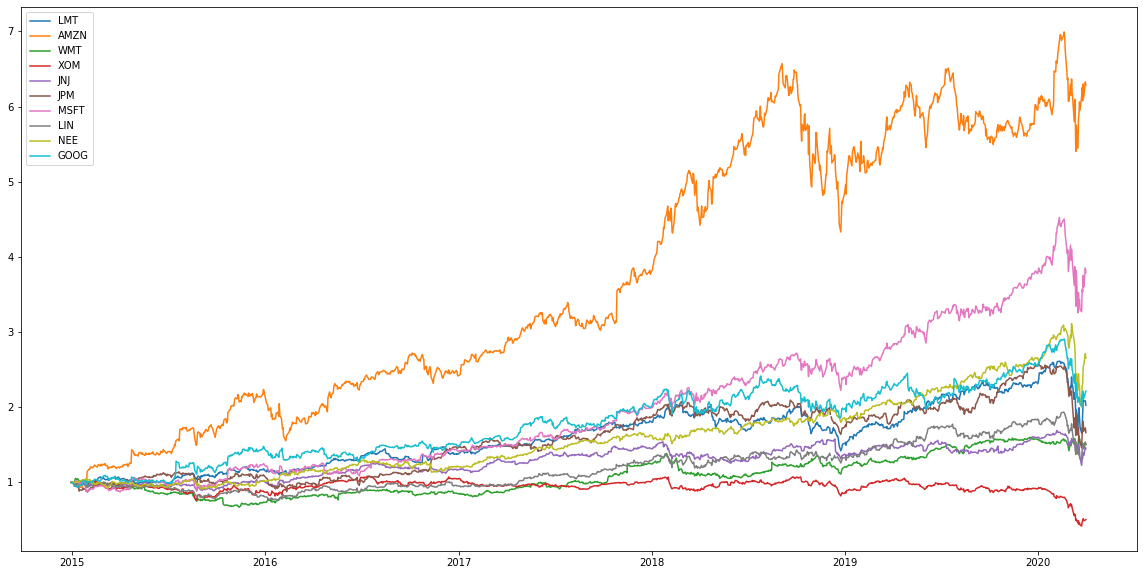

In [3]:
fig, ax = plt.subplots(figsize=(20,10))

for sym in list(zip(*corps_dict.values()))[0]:
    ax.plot(df_price[sym]/df_price[sym].iloc[0], label=sym)
ax.legend()
plt.show()

In [6]:
df_ret = df_price/df_price.shift(1) # daily return
dropIdx = df_ret["AAPL"].index[ df_ret["AAPL"].apply( np.isnan ) ]
df_ret = df_ret.drop( dropIdx )
logret = np.log( df_ret.to_numpy() ) # daily log-return
logret = logret / logret.std() # re-scale

logret_tensor = torch.from_numpy( logret ).float()

Epoch:250, LossD/G:1.3715/-0.6722


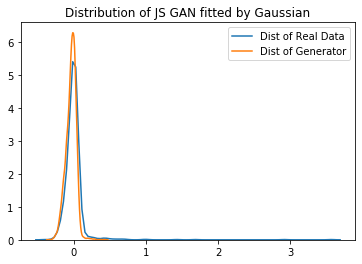

Epoch:500, LossD/G:1.3509/-0.6622


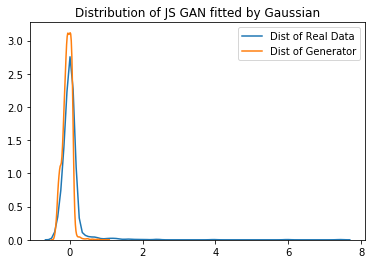

Epoch:750, LossD/G:1.3279/-0.6638


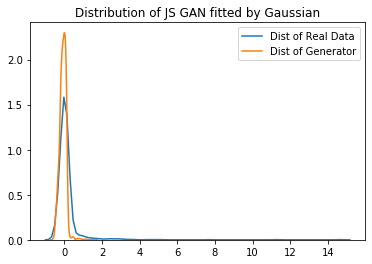

Epoch:1000, LossD/G:1.3100/-0.6551


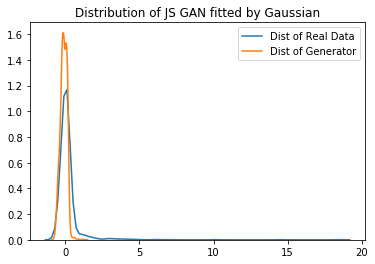

Epoch:1250, LossD/G:1.2875/-0.6265


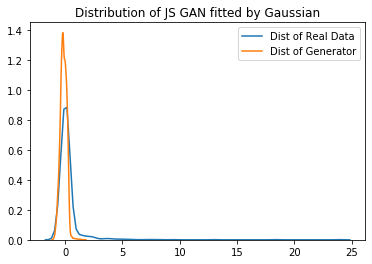

Epoch:1500, LossD/G:1.2687/-0.6426


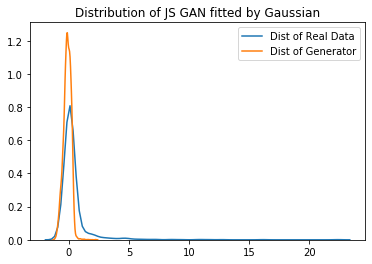

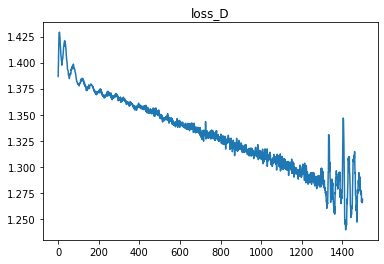

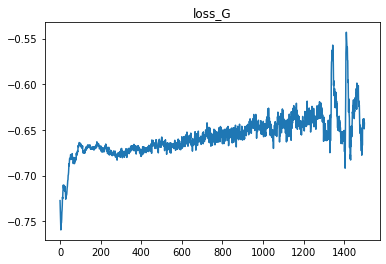

Time for running this cell: 254.81s


In [15]:
## Fitted by Gaussian
s0 = time.time()
f1 = fgan(50, 0.0, device, epsilon=1e-5)
f1.dist_init(true_type='Gaussian', cont_type='Gaussian',
             c_cov=1.0, c_loc=1.0)
f1.data_init(batch_size=25, data=logret_tensor)
f1.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f1.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f1.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Gaussian fits the distribution somehow well, though with a more symmetric distribution.  

Epoch:250, LossD/G:1.3862/-0.6944


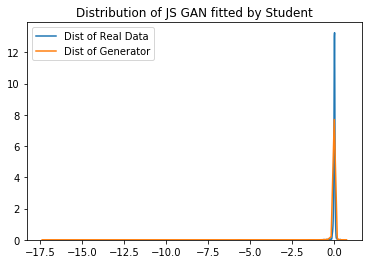

Epoch:500, LossD/G:1.3804/-0.6966


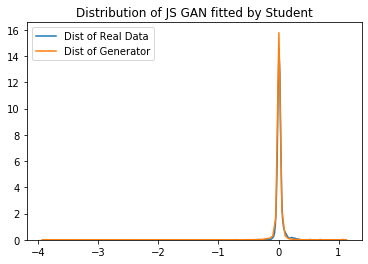

Epoch:750, LossD/G:1.3748/-0.6886


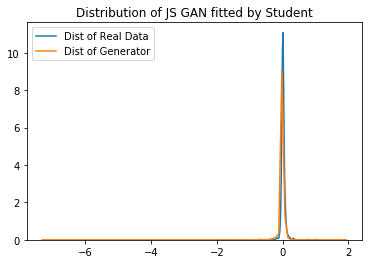

Epoch:1000, LossD/G:1.3689/-0.6876


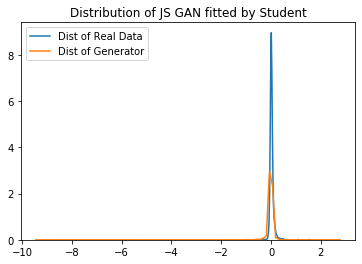

Epoch:1250, LossD/G:1.3631/-0.6880


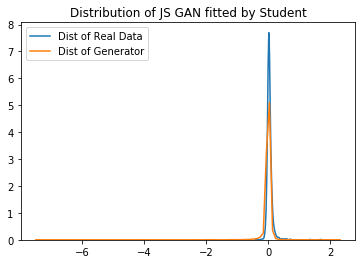

Epoch:1500, LossD/G:1.3606/-0.6806


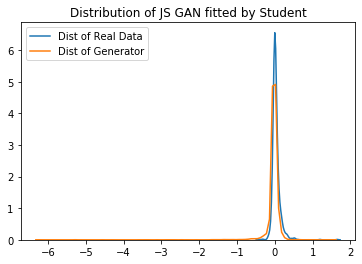

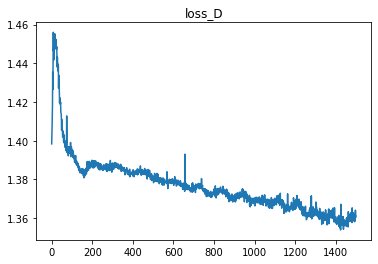

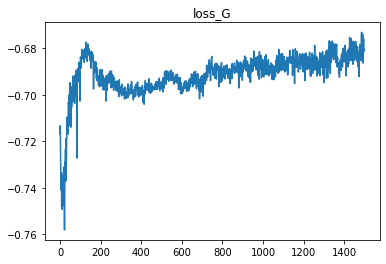

Time for running this cell: 144.03s


In [16]:
## Fitted by Student-t
s0 = time.time()
f2 = fgan(50, 0.0, device, epsilon=1e-5)
f2.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f2.data_init(batch_size=50, data=logret_tensor)
f2.net_init(hidden_units=[100, 25], elliptical=False, use_bias=True,
           init_D='xavier', init_D1=0.025, init_G='kendall',
           activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f2.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f2.fit(floss='js', epochs=1500, avg_epochs=50,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

Student-$t$ seems a better fit than Gaussian though with more oscillations. 

In [17]:
from fgan import fgan

Epoch:250, LossD/G:1.3888/-0.6984


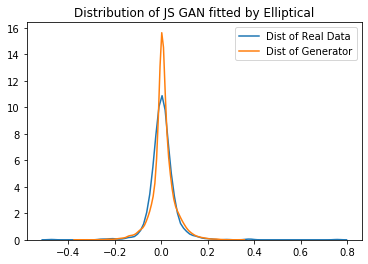

Epoch:500, LossD/G:1.3840/-0.6908


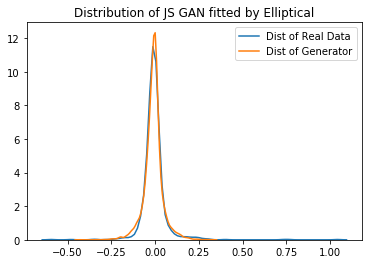

Epoch:750, LossD/G:1.3771/-0.6907


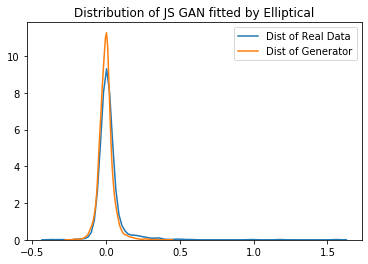

Epoch:1000, LossD/G:1.3727/-0.6884


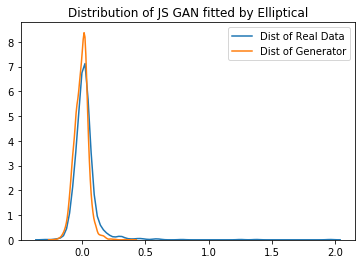

Epoch:1250, LossD/G:1.3730/-0.6911


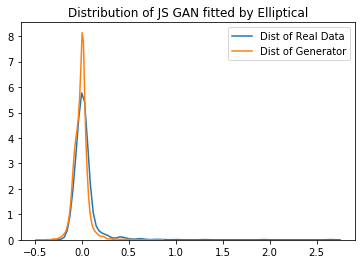

Epoch:1500, LossD/G:1.3664/-0.6806


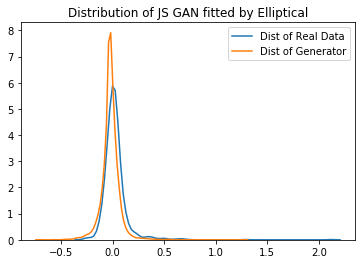

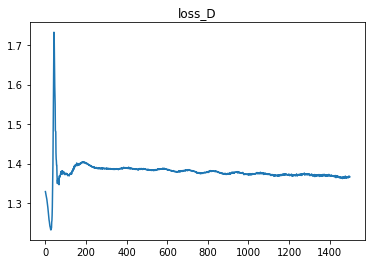

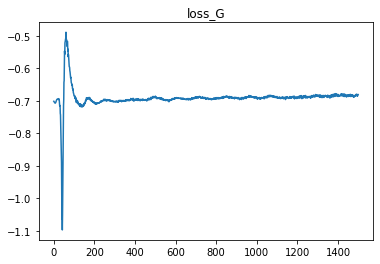

Time for running this cell: 164.31s


In [18]:
## Fitted by Elliptical
s0 = time.time()
f3 = fgan(50, 0.0, device, epsilon=1e-5)
f3.dist_init(true_type='Student', t_df=2, cont_type='Gaussian',
            c_cov=5.0, c_loc=5.0)
f3.data_init(batch_size=50, data=logret_tensor)
f3.net_init(hidden_units=[100, 25], hidden_units_G=[25, 10], input_dim_G=10, use_bias=True,
            elliptical=True, init_D='xavier', init_D1=0.025, init_G='kendall',
            activation_D1='LeakyReLU', activation_D='LeakyReLU', activation_Dn='LeakyReLU' )

f3.optimizer_init(lr_d=0.001, lr_g=0.1, d_steps=3, g_steps=1)
f3.fit(floss='js', epochs=1500, avg_epochs=50, inverse_gaussian=False,
      verbose=250, show=True, logd_trick=False)
print( "Time for running this cell: {:.2f}s".format(time.time()-s0) )

So general elliptical distribution seems with better fitting performance here than Gaussian and Student-$t$. 

### Outlier detection by Discriminator

Outlier is defined as samples whose discriminator values larger or smaller than $99.75$, or $1$ percentile estimated from learned generator, respectively.

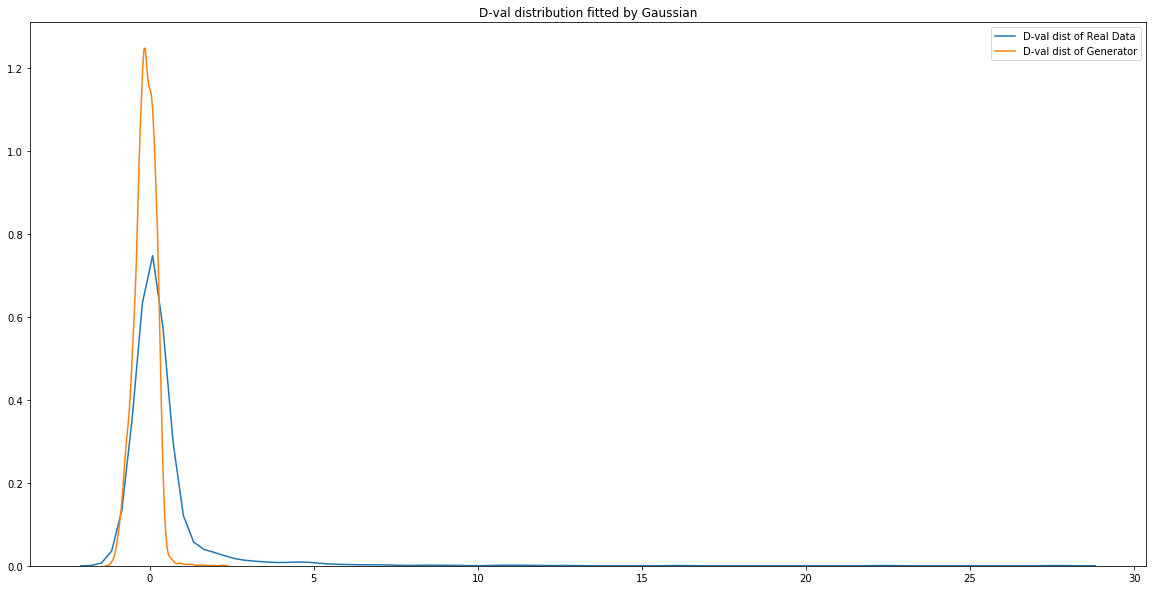

145 outliers are detected by Gaussian fit


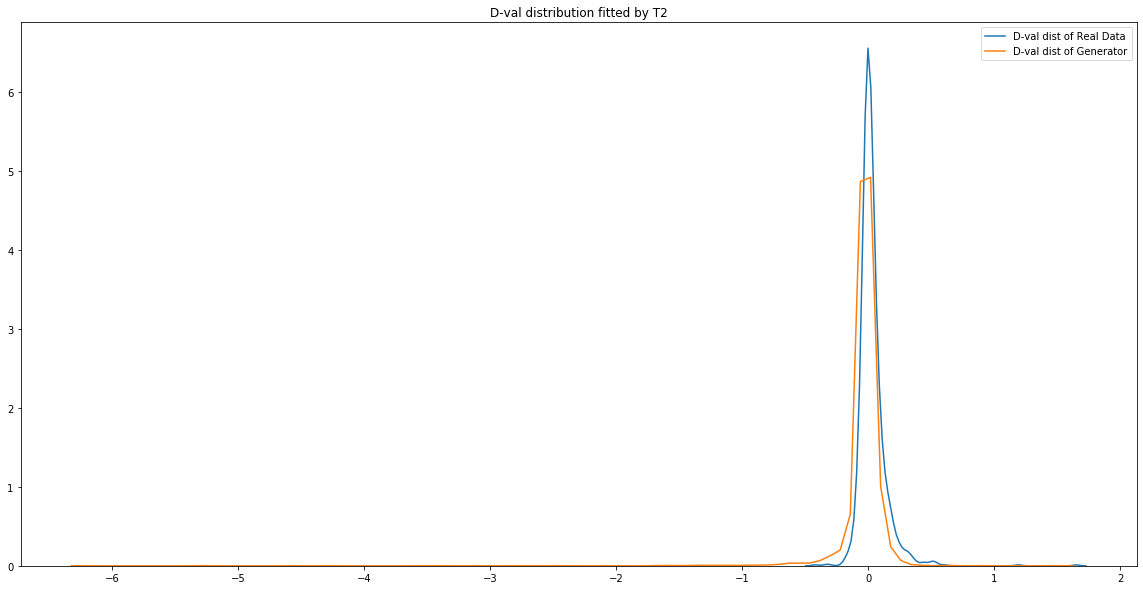

19 outliers are detected by T2 fit


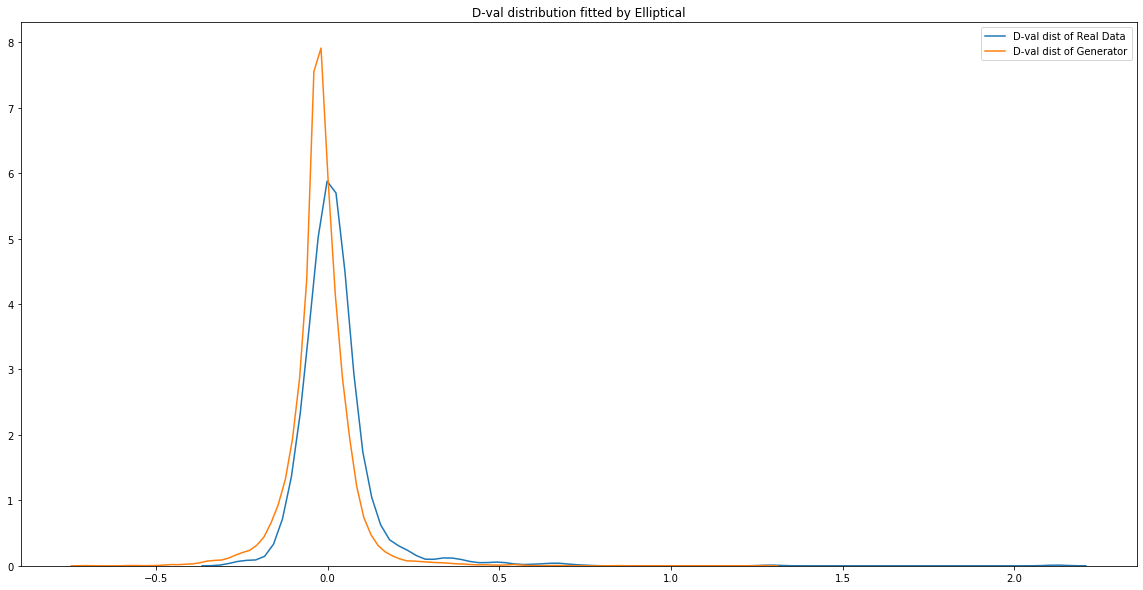

17 outliers are detected by Elliptical fit


In [19]:
outlierIndex = {}
model = ['Gaussian', 'T2', "Elliptical"]

for i in range(3):
    f = eval("f"+str(i+1))
    fig, ax = plt.subplots(figsize=(20,10))

    real_D = f.netD(f.Xtr.to(device))[1].detach().cpu().numpy()
    ## generating sample score
    if not f.elliptical:
        if f.true_type == 'Student':
            temp_z = torch.randn(10000, f.p).to(device) # [N, p]
            temp_z.div_(torch.sqrt(f.t_chi2_d.sample((10000, 1))/f.t_df).to(device) + f.epsilon)
            temp_g = f.netG(temp_z)
        elif f.true_type == 'Gaussian':
            temp_g = f.netG(torch.randn(10000, f.p).to(device))

    else:
        temp_u = torch.randn(10000, f.p).to(device)
        temp_u.data.div_(temp_u.norm(2, dim=1).view(-1, 1) + f.epsilon)
        if f.inverse_gaussian:
            temp_xi1 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2 = torch.randn(10000, f.input_dim_G//2).to(device)
            temp_xi2.data = 1/(torch.abs(temp_xi2.data) + f.epsilon)
            temp_xi = f.netGXi(torch.cat([temp_xi1, temp_xi2], dim=1)).view(10000, -1)
        else:
            temp_xi = f.netGXi(torch.randn(10000, f.input_dim_G).to(device)).view(10000, -1)
        temp_g = f.netG(temp_u, temp_xi)

    gene_D = f.netD(temp_g)[1].detach().cpu().numpy()

    sns.distplot(f.real_D, hist=False, label='D-val dist of Real Data')
    sns.distplot(f.gene_D, hist=False, label='D-val dist of Generator')
    plt.legend()
    plt.title('D-val distribution fitted by ' + model[i])
    plt.show()
    
    # outlier is defined as data with discriminator value larger(smaller) than
    # 99.75(1) percentile estimated from learned generator.
    outlierIndex[i] = (real_D > np.percentile(gene_D, 99.75)) | (real_D < np.percentile(gene_D, 1))
    print( "{} outliers are detected by {} fit".format( outlierIndex[i].sum(), model[i]) )
    #print(np.std(gene_D))



In [21]:
## Import S&P 500 Index and see what happens at outlier date.
import pandas_datareader.data as web
import datetime

SPX = web.DataReader(['sp500'], 'fred', START, END)
SPX = SPX.loc[df_ret.index]

/home/wzengad/anaconda3/envs/python36/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


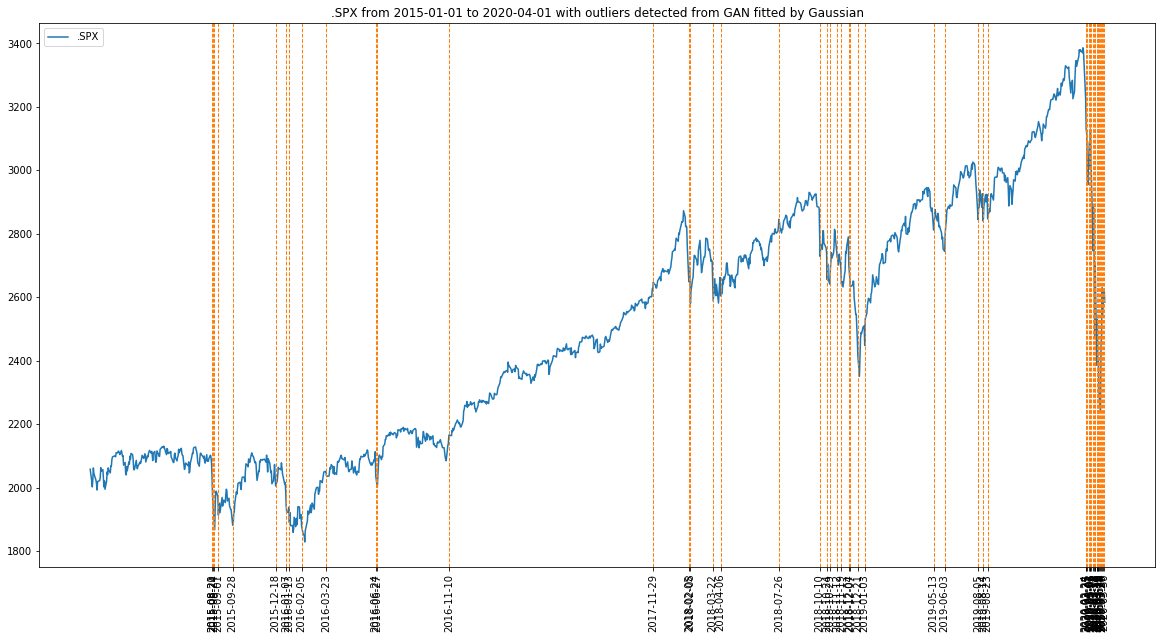

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[0]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected from GAN fitted by Gaussian".format(START, END) )
plt.show()

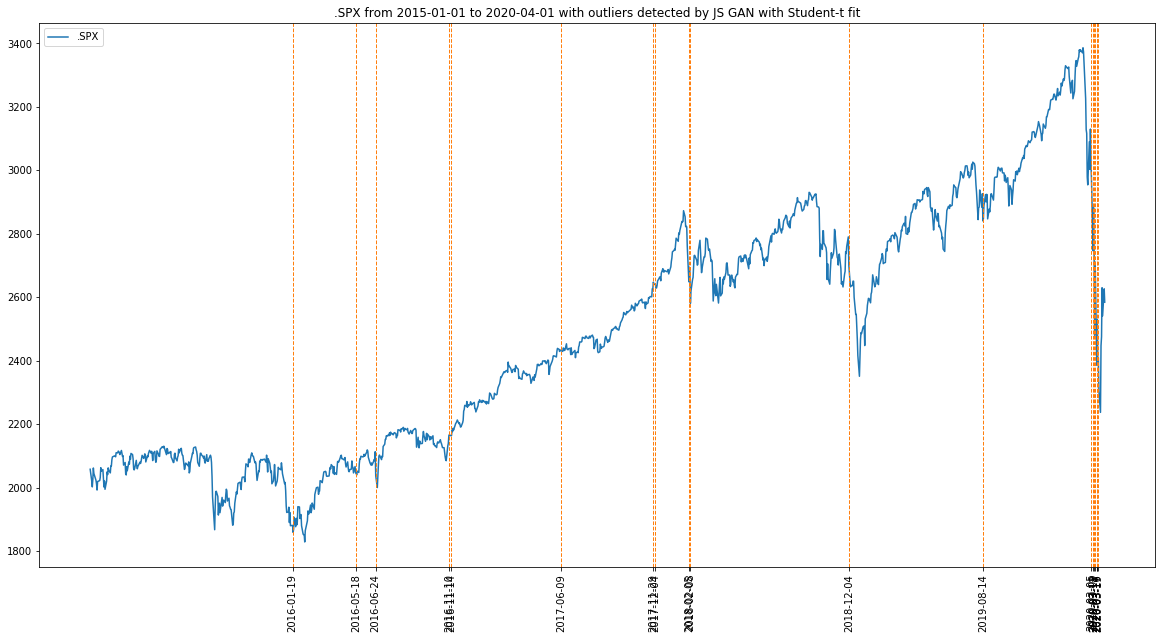

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[1]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected by JS GAN with Student-t fit".format(START, END) )
plt.show()

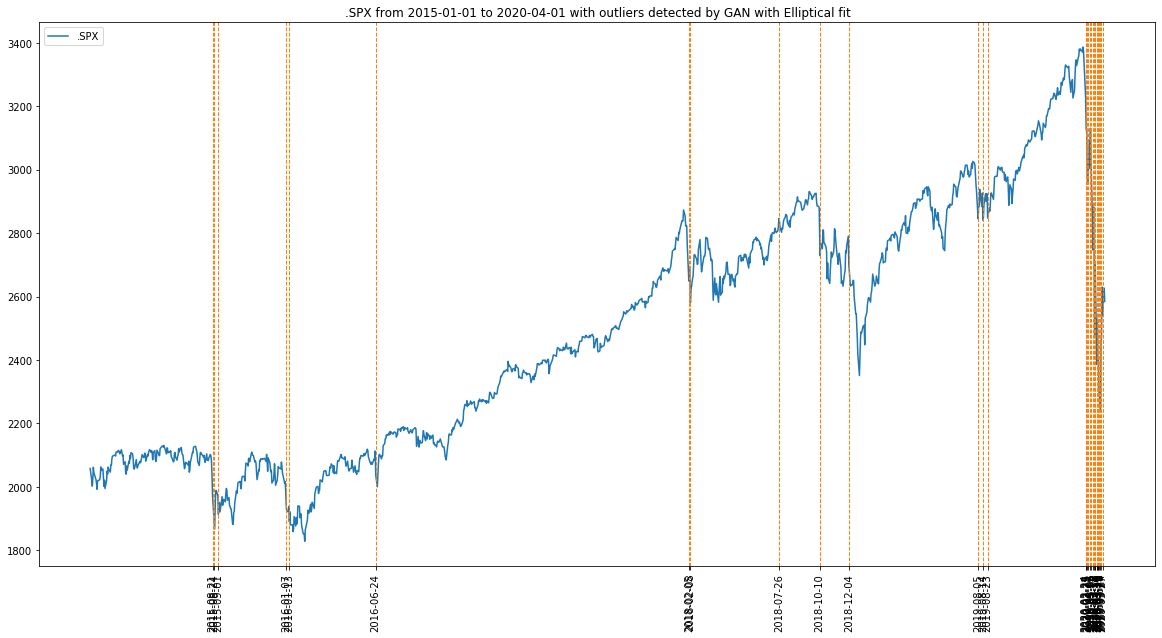

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SPX, label=".SPX")
outlierDate = SPX.index[outlierIndex[2]].tolist()
for idx in outlierDate:
    ax.axvline(x=idx, color='C1', linestyle='--', lw=1.0)
tickList = outlierDate
plt.xticks(outlierDate, [ x.strftime("%Y-%m-%d") for x in outlierDate ], rotation=90)
ax.legend()
ax.set_title( ".SPX from {} to {} with outliers detected by GAN with Elliptical fit".format(START, END) )
plt.show()

## 3. Robust PCA

Now we reselect daily prices of 50 stocks during the period between 2007-01-01 and 2018-12-31. This includes the 2008 financial tsunami.  

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit( logret )

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

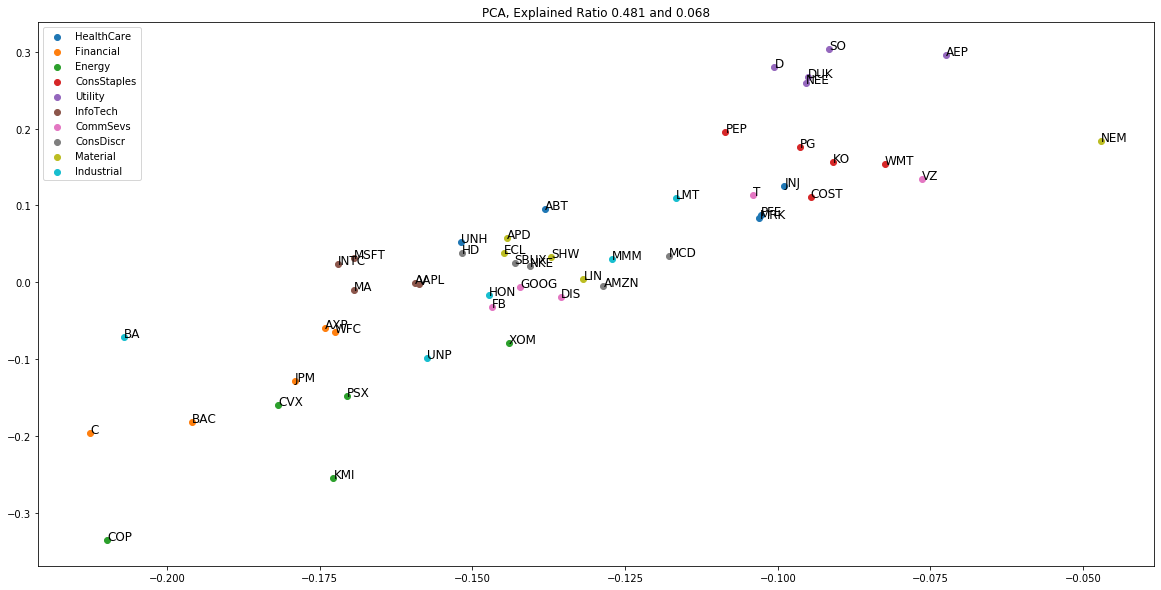

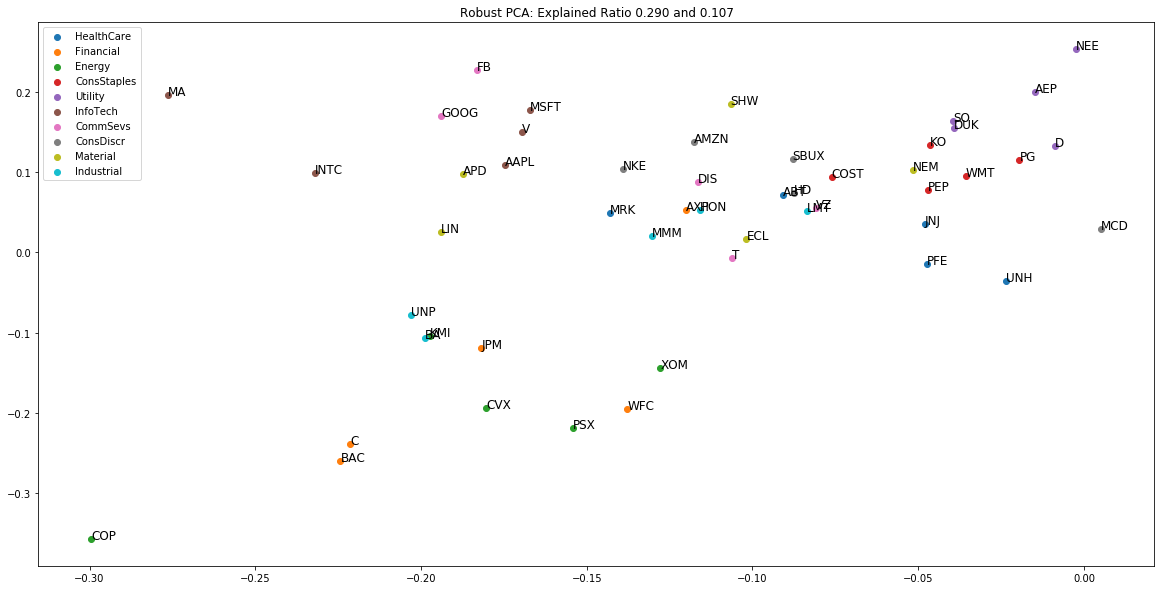

In [24]:
cov0 = pca.get_covariance()
s0, v0 = scipy.linalg.eigh(cov0)
fig, ax = plt.subplots(figsize=(20,10))
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v0[idx,-1], v0[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v0[:,-1][i], v0[:,-2][i]),size=12)
plt.legend()
plt.title('PCA, Explained Ratio %.3f and %.3f' % ((s0/s0.sum())[-1], (s0/s0.sum())[-2]))
plt.show()

fig, ax = plt.subplots(figsize=(20,10))
f = eval("f"+str(1))
A = f.netG.weight.data.cpu().numpy()
cov = np.matmul(A.T, A)
s, v = scipy.linalg.eigh(cov)
for sect in set(sects):
    idx = (np.array(sects) == sect)
    ax.scatter(v[idx,-1], v[idx,-2], label=sect)
for i, txt in enumerate(corps):
    ax.annotate(txt, (v[:,-1][i], v[:,-2][i]),size=12)
plt.legend()
plt.title('Robust PCA: Explained Ratio %.3f and %.3f' % 
          ((s/s.sum())[-1], (s/s.sum())[-2]))
plt.show()

